<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/News_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 42.2MB/s 
     |████████████████████████████████| 460kB 16.6MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


**News Crawler**

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import html

class News:
  def __init__(self):
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_ranking(self, page=1, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = list(range(1,page+1))
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=RANK&date=' + date + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")

      div = bs_obj.find_all('div', {'class':'hotNewsList'})
      li+=[html.unescape(x['href']) for x in div[0].find_all('a')]
    return li

  def get_main(self, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y-%m-%d")) if date == '1' else date
    url = 'https://finance.naver.com/news/mainnews.nhn'
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    return [x.find_all('a')[0]['href'] for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
    
  def get_breaking(self):
    pass

  # 시황 전망: 401
  # 기업 종목분석: 402
  # 해외 증시: 403
  # 채권 선물: 404
  # 공시 메모: 406
  # 환율: 429
  def get_focus(self, page=1, code=402, date='1', ):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = range(0,page)
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=LSS3D&section_id=101&section_id2=258&section_id3='\
      + str(code) +  '&date=' + str(date) + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")
      temp = [html.unescape(x.find_all('a')[0]['href']) for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
      # 업데이트 가능
      li+=[x.replace('§', '&sect') for x in temp]
    return li

  def get_article(self, url):
    url = 'https://finance.naver.com/' + url
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    title = ' '.join(bs_obj.find_all('div', {'class': 'article_info'})[0].find_all('h3')[0].get_text().split())
    context = bs_obj.find_all('div', {'class': 'articleCont'})[0]
    try:
      subheading = context.find_all('strong')[0].get_text()
    except:
      subheading = ''
    t = ' '.join(context.get_text().split())
    text = t[:t.find('@')]
    text = text.replace(subheading, '')
    return title, subheading, text

In [3]:
from multiprocessing import Pool

news = News()
news_list = news.get_ranking(4)
with Pool(30) as p:
    li = p.map(news.get_article, news_list)
li = np.array(li)

dic = {'Title':li[:,0], 'Subheading':li[:,1], 'Text':li[:,2]}
df = pd.DataFrame.from_dict(dic)
df

,Title,Subheading,Text
0,"기관이 14거래일 동안 620억 담은 이 종목…""합병 이후도 기대된다""",,[머니투데이 구단비 기자] /그래픽=최헌정 디자인기자GS리테일은 최근 기관이 가장 ...
1,AMC 95% 이상 폭등···S&P;는 0.14%↑ [데일리 국제금융시장],"다우 0.073% 상승, 나스닥도 0.14% 올라WTI, 1.6% 오른 배럴당 68...",뉴욕증권거래소(NYSE) 내부. /AFP연합뉴스[서울경제] 게임스톱과 함께 개미들의...
2,한달간 공매도 쏟아진 삼성전자 1.1%↓… HMM은 되레 21% 올라,,"공매도 재개 한달, 충격은 없었다 1년 넘게 금지됐던 공매도가 재개된 뒤 한 달이 ..."
3,"사상 최고치 앞둔 코스피…""가격저항 매우 강하다""",,[머니투데이 조준영 기자] [[개장전]] [서울=뉴시스]홍효식 기자 = 코스피가 전...
4,뉴욕증시 상승 마감…'문이과 통합' 첫 수능 모의평가 [모닝브리핑],,"◆뉴욕증시, 고용보고서 발표 앞두고 상승…다우 0.07%↑뉴욕 증시에서 주요지수들은..."
...,...,...,...
90,"[클릭 e종목] ""CJ ENM, 작년말부터 이어진 호실적 2Q에도 이어질 것""",사측 제시 실적 목표치 훌쩍 웃돌 전망티빙 가입자 100만 돌파…투자 지속 예상,[아시아경제 이민우 기자] CJ ENM이 올해 2분기 시장전망치(컨센서스)를 웃도는...
91,"신한금투 ""아프리카TV, 더 사도 됩니다…목표주가 8.3%↑""",,(서울=뉴스1) 박응진 기자 = 신한금융투자는 다양한 커뮤니케이션 채널의 후원시스템...
92,"아프리카TV, '별풍선' 보편화 고성장세 기대…목표가 8.3%↑-신한",,[머니투데이 김태현 기자] 신한금융투자는 아프리카TV에 대해 플랫폼과 광고 등 주요...
93,"하나금투, ""CJ ENM 2Q 실적 전망치 크게 웃돌 것""...목표가 11%↑","[하나금융투자 보고서]목표가 25만원→27만5,000원 상향 조정2Q 영업익 844...",[서울경제] 하나금융투자가 CJ ENM(035760)의 올 2분기 실적이 미디어 부...


In [4]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2021-06-03 00:53:00--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.213.128, 2607:f8b0:400c:c0a::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   101MB/s    in 1.1s    

2021-06-03 00:53:01 (101 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Th

(-0.5, 1199.5, 799.5, -0.5)

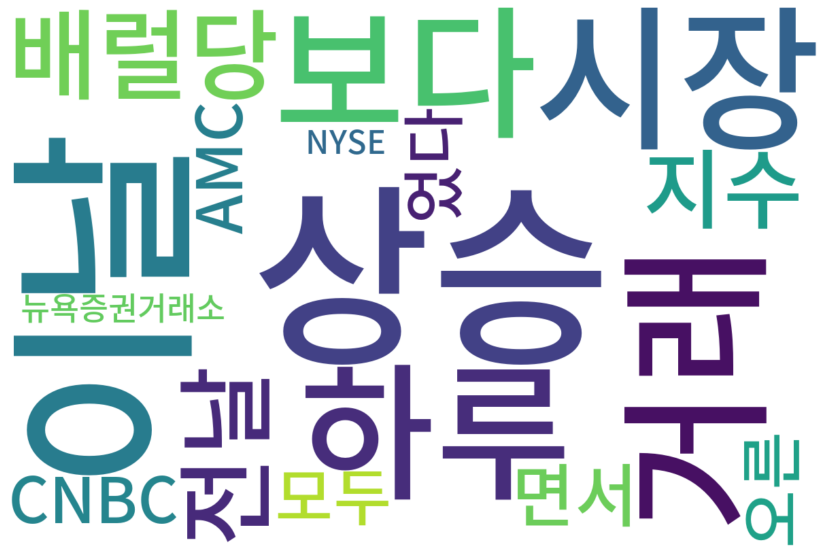

In [51]:
from konlpy.tag import Hannanum

hannanum = Hannanum()
text = hannanum.morphs(df['Text'][1])

# 정제/정규화
text = ([x for x in text if len(x) > 1])
d = {i:text.count(i) for i in set(text) if text.count(i) > 1}
text = ' '.join(d.keys())
stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '6월', '2일', '마감', \
              'ㄴ다', 'ㄴ다는', '기관', '외국인', '결정', '증시', '까지', '코스피', '었던', '하고', '으로', '따르', '었지만', '보이', '위하', '었다']
wordcloud = WordCloud(stopwords = stop_words, \
                      font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                      background_color='white', \
                      width=1200, height=800).generate(text)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [54]:
# https://wikidocs.net/22530
from konlpy.tag import Hannanum
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class Analyser:
  def __init__(self, df):
    self.df = df

  def get_tokenized(self, text):
    hannanum = Hannanum()
    return hannanum.morphs(text) 

  def get_cleaned(self, text):
    text = ([x for x in text if len(x) > 1])
    d = {i:text.count(i) for i in set(text) if text.count(i) > 1}
    words = ' '.join(d.keys())
    return words

  def get_wordcloud(self, words):
    stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '6월', '2일', '마감', \
                  '코스닥', '규모', '기관', '외국인', '결정', '증시', '3일', '코스피', '급등', '개인', '신영증권']
    wordcloud = WordCloud(stopwords = stop_words, \
                          font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                          background_color='white', \
                          width=1200, height=800).generate(words)
    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")




In [56]:
analyser = Analyser(df)

In [73]:
li = []

for i in range(5):
  words = analyser.get_tokenized(analyser.df['Text'][i])
  words = analyser.get_cleaned(words)
  words = words.split()
  li += words

['[', '머니투데이', '구단비', '기', '이', '자', ']', '/그래픽=최헌정', '디자인기자GS리테일', '은', '최근', '기관', '이', '가장', '사랑', '하', '는', '주식', '이', '다', '.', '기관', '은', '14거래', '이', 'ㄹ', '연속', 'GS리테', '이', 'ㄹ', '주식', '을', '사', '아', '들이', '었다', '.', '2', '이', 'ㄹ', 'GS리테일', '은', '전', '거래', '이', 'ㄹ', '대비', '200원(0.', '51', '%)', '하락', '하', 'ㄴ', '3만9000원', '에', '마감', '하', '었다', '.', '이날', '소폭', '하락', '하', '었지', '말', 'ㄴ', 'GS리테일', '은', '지난달', '31일', '5', '%', '이상', '상승', '하', '며', '3만원', '대', '후반', '으로', '훌쩍', '뛰', '었다', '.', '기관', '의', '매수세가', '몰리', 'ㄴ', '결과', '이', '다', '.', '기관', '은', '지난달', '13일', '부터', '14거래', '이', 'ㄹ', '동안', '624억원', '어치', '를', '담', '아다', '.', '같', '은', '기간', '전체', '매수액', '은', '2조4152억원', '이', '다', '.', 'GS리테일', '은', '지난해', '5월', '4만4400원', '까지', '치솟', '으며', '52주', '신', '고가', '를', '새로', '쓰', '었지만', '이후', '조정', '을', '받', '으며', '3만원', '대', '초반', '까지', '하락', '하', '었다', '.', '올초', '에도', '3만5000원', '대로', '시작', '하', '어', '5개월', '넘', '게', '3만원', '대', '중후반', '을', '매', 'ㅁ', '도는', '횡보세', '를', '보이', '어',

(-0.5, 1199.5, 799.5, -0.5)

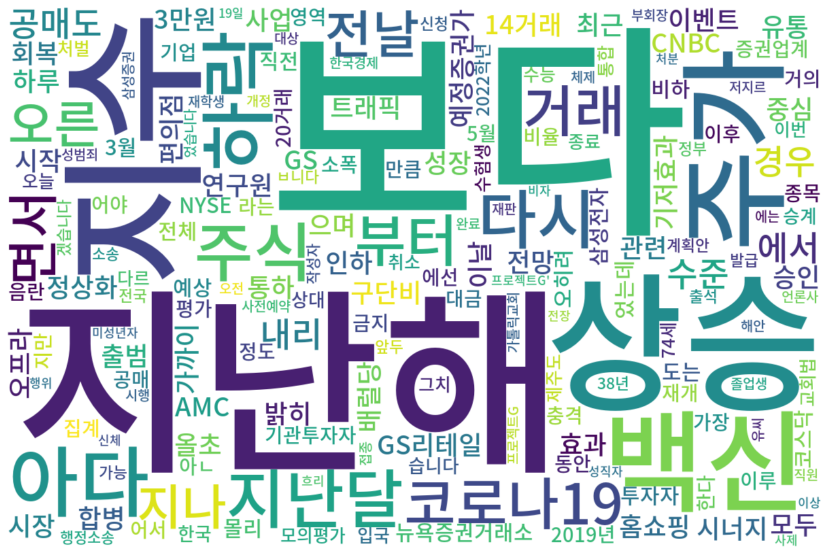

In [75]:
from konlpy.tag import Hannanum
# 정제/정규화

text = ' '.join(li)
stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '6월', '2일', '마감', \
              'ㄴ다', 'ㄴ다는', '기관', '외국인', '결정', '증시', '까지', '코스피', '었던', '하고', '으로', '따르', '었지만', '보이', '위하', '었다']
wordcloud = WordCloud(stopwords = stop_words, \
                      font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                      background_color='white', \
                      width=1200, height=800).generate(text)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")